## Prepare Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [ ]:
# Mount and define data dir
from google.colab import drive
drive.mount('/content/drive')
datadir = "."
save_dir = "/content/drive/My Drive/"

Mounted at /content/drive


In [ ]:
def load_pet_dataset(train_transform = None, test_transform = None):
    OxfordIIITPet = datasets.OxfordIIITPet
    if os.path.isdir(datadir+ "oxford-iiit-pet"):
      do_download = False
    else:
      do_download = True
    training_set = OxfordIIITPet(root = datadir,
                             split = 'trainval',
                             transform = train_transform,
                             download = do_download)

    test_set = OxfordIIITPet(root = datadir,
                           split = 'test',
                           transform = test_transform,
                           download = do_download)
    return training_set, test_set


100%|██████████| 791918971/791918971 [00:03<00:00, 250380627.81it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 119165253.12it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
Label: Abyssinian


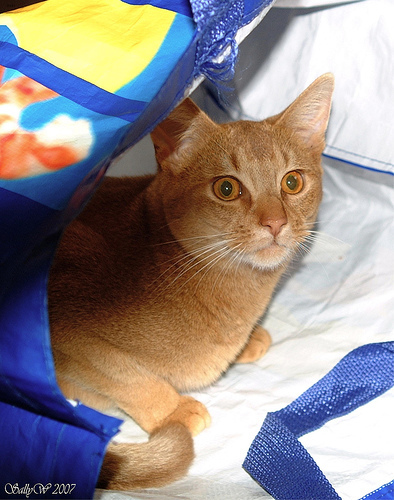

In [ ]:
train_set, test_set = load_pet_dataset()

# Display a sample in OxfordIIIPet dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", train_set.classes[train_set[sample_idx][1]])
train_set[sample_idx][0]

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# Apply data augmentation
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

## Data Preprocess

In [ ]:
# Apply data augmentation, 224 -> 299， change normalize to clip's
train_transform = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4814, 0.4578, 0.4082],
                                 std= [0.268, 0.2613, 0.2757]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(299),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4814, 0.4578, 0.4082],
                                 std= [0.268, 0.2613, 0.2757]),
        ])

In [ ]:
train_set, test_set = load_pet_dataset(train_transform, test_transform)
train_loader = DataLoader(dataset=train_set,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_set,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)


## Helper Functions

In [ ]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

In [ ]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

## Fine-Tune Pre-trained Network on Pets

In [ ]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images)
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [ ]:
device = 'cuda'
# loads a pre-trained ResNet-34 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

target_class = 37
# TO DO: replace the last layer with a new linear layer for Pets classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37)

model = model.to(device)
display_model(model) # displays the model structure and parameter count

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


- conv1                                    :                9408               
- bn1                                      :                128                
- relu                                     :                 0                 
- maxpool                                  :                 0                 
- layer1                                   :               215808              
- layer2                                   :              1219584              
- layer3                                   :              7098368              
- layer4                                   :              14964736             
- avgpool                                  :                 0                 
- fc                                       :               75813               
--Total                                    :          23583845 params          --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(6

In [ ]:
# Training Setting. Feel free to change.
num_epochs = 30
test_interval = 4

# TO DO: set initial learning rate
learn_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# TO DO: define your learning rate scheduler, e.g. StepLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
# StepLR(optimizer, step_size=30, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) # 3 change to 6
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []


# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    metric_value = test(test_loader, model, criterion)[0]
    lr_scheduler.step(metric_value)
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
          print("Saving Model")
          save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance



Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.87it/s]

Mean Accuracy: 0.8934
Avg loss: 0.5825874872248749
Loss for Training on epoch 0 is 1.591215968132019 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.85it/s]


Mean Accuracy: 0.9505
Avg loss: 0.35447447926833714
Training accuracy on epoch 0 is 0.9505434782608696 



Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.84it/s]


Mean Accuracy: 0.8934
Avg loss: 0.5825874872248749
Testing accuracy on epoch 0 is 0.8934314527119106 

Saving Model



Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.79it/s]

Mean Accuracy: 0.8942
Avg loss: 0.38384793146417057
Loss for Training on epoch 1 is 0.2560071349143982 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.77it/s]

Mean Accuracy: 0.9921
Avg loss: 0.075983717459543
Training accuracy on epoch 1 is 0.9921195652173913 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.77it/s]


Mean Accuracy: 0.8942
Avg loss: 0.38384793146417057
Testing accuracy on epoch 1 is 0.8942491142000545 

Saving Model



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.73it/s]

Training ...:   8%|▊         | 3/40 [05:48<1:08:23, 110.92s/it]

Mean Accuracy: 0.9229
Avg loss: 0.3038477625633622
Loss for Training on epoch 2 is 0.07280927896499634 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.73it/s]

Training ...:  10%|█         | 4/40 [07:17<1:01:27, 102.43s/it]

Mean Accuracy: 0.9081
Avg loss: 0.337845117415719
Loss for Training on epoch 3 is 0.034724555909633636 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Mean Accuracy: 0.9177
Avg loss: 0.3103019661944488
Loss for Training on epoch 4 is 0.022192373871803284 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.73it/s]

Mean Accuracy: 0.9997
Avg loss: 0.00769485000938434
Training accuracy on epoch 4 is 0.9997282608695652 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]


Mean Accuracy: 0.9177
Avg loss: 0.3103019661944488
Testing accuracy on epoch 4 is 0.9176887435268466 

Saving Model



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.73it/s]

Training ...:  15%|█▌        | 6/40 [11:00<59:38, 105.25s/it]  

Mean Accuracy: 0.9245
Avg loss: 0.28442190173242626
Loss for Training on epoch 5 is 0.013689289800822735 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  18%|█▊        | 7/40 [12:29<55:03, 100.12s/it]

Mean Accuracy: 0.9248
Avg loss: 0.28231698640718544
Loss for Training on epoch 6 is 0.01048955786973238 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  20%|██        | 8/40 [13:59<51:35, 96.74s/it] 

Mean Accuracy: 0.9253
Avg loss: 0.29123729391922726
Loss for Training on epoch 7 is 0.00906639639288187 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Mean Accuracy: 0.9297
Avg loss: 0.2805958862962394
Loss for Training on epoch 8 is 0.008665339089930058 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 1.0000
Avg loss: 0.002910622997723263
Training accuracy on epoch 8 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]


Mean Accuracy: 0.9297
Avg loss: 0.2805958862962394
Testing accuracy on epoch 8 is 0.9296811120196239 

Saving Model



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  25%|██▌       | 10/40 [17:41<51:08, 102.28s/it]

Mean Accuracy: 0.9283
Avg loss: 0.2778467813763639
Loss for Training on epoch 9 is 0.008159098215401173 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  28%|██▊       | 11/40 [19:10<47:33, 98.38s/it] 

Mean Accuracy: 0.9291
Avg loss: 0.27843656142017453
Loss for Training on epoch 10 is 0.00835336185991764 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  30%|███       | 12/40 [20:40<44:39, 95.69s/it]

Mean Accuracy: 0.9264
Avg loss: 0.284238178893153
Loss for Training on epoch 11 is 0.007832345552742481 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9291
Avg loss: 0.2794404948001792
Loss for Training on epoch 12 is 0.008181639946997166 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Mean Accuracy: 1.0000
Avg loss: 0.002917300456139291
Training accuracy on epoch 12 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  32%|███▎      | 13/40 [22:52<48:04, 106.83s/it]

Mean Accuracy: 0.9291
Avg loss: 0.2794404948001792
Testing accuracy on epoch 12 is 0.9291360043608613 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  35%|███▌      | 14/40 [24:22<44:02, 101.63s/it]

Mean Accuracy: 0.9275
Avg loss: 0.2820685629186959
Loss for Training on epoch 13 is 0.008297485299408436 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  38%|███▊      | 15/40 [25:52<40:49, 97.98s/it] 

Mean Accuracy: 0.9291
Avg loss: 0.2775244418017823
Loss for Training on epoch 14 is 0.008231209591031075 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Training ...:  40%|████      | 16/40 [27:21<38:11, 95.48s/it]

Mean Accuracy: 0.9300
Avg loss: 0.2781794135426653
Loss for Training on epoch 15 is 0.00819330383092165 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9250
Avg loss: 0.28347603273417415
Loss for Training on epoch 16 is 0.008021616376936436 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0028683831754686504
Training accuracy on epoch 16 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  42%|████▎     | 17/40 [29:34<40:52, 106.64s/it]

Mean Accuracy: 0.9250
Avg loss: 0.28347603273417415
Testing accuracy on epoch 16 is 0.9250476969201418 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  45%|████▌     | 18/40 [31:03<37:13, 101.53s/it]

Mean Accuracy: 0.9283
Avg loss: 0.28396060523288
Loss for Training on epoch 17 is 0.00805698987096548 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  48%|████▊     | 19/40 [32:33<34:16, 97.92s/it] 

Mean Accuracy: 0.9261
Avg loss: 0.2833426087966253
Loss for Training on epoch 18 is 0.008158632554113865 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  50%|█████     | 20/40 [34:03<31:48, 95.43s/it]

Mean Accuracy: 0.9245
Avg loss: 0.28901848323835894
Loss for Training on epoch 19 is 0.008137470111250877 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9264
Avg loss: 0.2830212534212604
Loss for Training on epoch 20 is 0.007784992456436157 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0027845119856747575
Training accuracy on epoch 20 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  52%|█████▎    | 21/40 [36:15<33:45, 106.62s/it]

Mean Accuracy: 0.9264
Avg loss: 0.2830212534212604
Testing accuracy on epoch 20 is 0.9264104660670482 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  55%|█████▌    | 22/40 [37:45<30:27, 101.52s/it]

Mean Accuracy: 0.9294
Avg loss: 0.27684291789372417
Loss for Training on epoch 21 is 0.00827515497803688 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  57%|█████▊    | 23/40 [39:14<27:44, 97.91s/it] 

Mean Accuracy: 0.9297
Avg loss: 0.27803199105607024
Loss for Training on epoch 22 is 0.0086032934486866 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  60%|██████    | 24/40 [40:44<25:26, 95.41s/it]

Mean Accuracy: 0.9302
Avg loss: 0.27766969732554825
Loss for Training on epoch 23 is 0.008232839405536652 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9286
Avg loss: 0.27942889267257576
Loss for Training on epoch 24 is 0.007872059009969234 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 1.0000
Avg loss: 0.002829476042875442
Training accuracy on epoch 24 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.73it/s]

Training ...:  62%|██████▎   | 25/40 [42:56<26:37, 106.49s/it]

Mean Accuracy: 0.9286
Avg loss: 0.27942889267257576
Testing accuracy on epoch 24 is 0.9285908967020987 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  65%|██████▌   | 26/40 [44:26<23:39, 101.42s/it]

Mean Accuracy: 0.9272
Avg loss: 0.28476357582057343
Loss for Training on epoch 25 is 0.009036951698362827 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  68%|██████▊   | 27/40 [45:56<21:12, 97.89s/it] 

Mean Accuracy: 0.9289
Avg loss: 0.27769932243973017
Loss for Training on epoch 26 is 0.008523764088749886 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  70%|███████   | 28/40 [47:25<19:05, 95.43s/it]

Mean Accuracy: 0.9283
Avg loss: 0.28349513896130796
Loss for Training on epoch 27 is 0.008066662587225437 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9280
Avg loss: 0.2748229479866809
Loss for Training on epoch 28 is 0.00809986237436533 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0027088436683447197
Training accuracy on epoch 28 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  72%|███████▎  | 29/40 [49:38<19:32, 106.61s/it]

Mean Accuracy: 0.9280
Avg loss: 0.2748229479866809
Testing accuracy on epoch 28 is 0.928045789043336 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  75%|███████▌  | 30/40 [51:07<16:54, 101.47s/it]

Mean Accuracy: 0.9291
Avg loss: 0.2791931301933424
Loss for Training on epoch 29 is 0.007573225535452366 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  78%|███████▊  | 31/40 [52:37<14:41, 97.92s/it] 

Mean Accuracy: 0.9283
Avg loss: 0.2804242012990189
Loss for Training on epoch 30 is 0.00839842576533556 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  80%|████████  | 32/40 [54:07<12:43, 95.40s/it]

Mean Accuracy: 0.9272
Avg loss: 0.2761365506348425
Loss for Training on epoch 31 is 0.008131599985063076 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9289
Avg loss: 0.2773375888836795
Loss for Training on epoch 32 is 0.007808959577232599 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0028998391494026473
Training accuracy on epoch 32 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  82%|████████▎ | 33/40 [56:19<12:26, 106.58s/it]

Mean Accuracy: 0.9289
Avg loss: 0.2773375888836795
Testing accuracy on epoch 32 is 0.92886345053148 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Training ...:  85%|████████▌ | 34/40 [57:49<10:09, 101.50s/it]

Mean Accuracy: 0.9289
Avg loss: 0.28475795373127893
Loss for Training on epoch 33 is 0.008215268142521381 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  88%|████████▊ | 35/40 [59:19<08:09, 97.94s/it] 

Mean Accuracy: 0.9270
Avg loss: 0.2825943301271262
Loss for Training on epoch 34 is 0.008462036028504372 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Training ...:  90%|█████████ | 36/40 [1:00:48<06:21, 95.47s/it]

Mean Accuracy: 0.9291
Avg loss: 0.27720322861368285
Loss for Training on epoch 35 is 0.008106224238872528 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Mean Accuracy: 0.9280
Avg loss: 0.2812532913260933
Loss for Training on epoch 36 is 0.007724418770521879 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Mean Accuracy: 1.0000
Avg loss: 0.002810863308319501
Training accuracy on epoch 36 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...:  92%|█████████▎| 37/40 [1:03:01<05:19, 106.62s/it]

Mean Accuracy: 0.9280
Avg loss: 0.2812532913260933
Testing accuracy on epoch 36 is 0.928045789043336 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Training ...:  95%|█████████▌| 38/40 [1:04:31<03:23, 101.52s/it]

Mean Accuracy: 0.9283
Avg loss: 0.2819044383499643
Loss for Training on epoch 37 is 0.00837762001901865 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]

Training ...:  98%|█████████▊| 39/40 [1:06:00<01:37, 97.96s/it] 

Mean Accuracy: 0.9300
Avg loss: 0.27504561020960583
Loss for Training on epoch 38 is 0.00787881389260292 



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]

Mean Accuracy: 0.9267
Avg loss: 0.2738209479199401
Loss for Training on epoch 39 is 0.00806371122598648 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0028560638933538877
Training accuracy on epoch 39 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Training ...: 100%|██████████| 40/40 [1:08:13<00:00, 102.34s/it]

Mean Accuracy: 0.9267
Avg loss: 0.2738209479199401
Testing accuracy on epoch 39 is 0.9266830198964295 



## Plotting of losses and accuracy

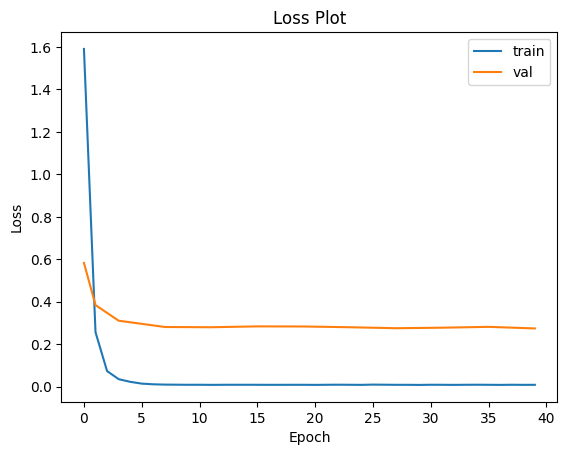

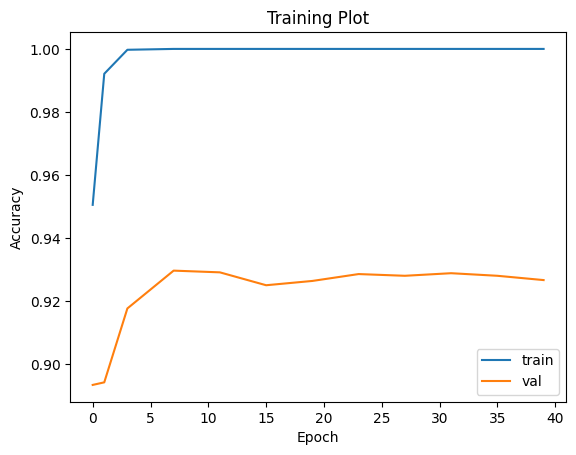

In [ ]:
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

## Evaluating trained model

In [ ]:
# TO DO: initialize your trained model as you did before so that you can load the parameters into it
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# replace last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37).to(device)

load_model(model, save_dir) # Load the trained weight

test_accuracy, test_loss= test(test_loader, model, criterion)
print(f"Testing accuracy is {str(test_accuracy)} \n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.72it/s]

Mean Accuracy: 0.9297
Avg loss: 0.2805958862962394
Testing accuracy is 0.9296811120196239 

